# Data preparation

## Library import

In [1]:
import random
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess, OptimalBinning
import statsmodels.api as sm

### Data import and overview

In [2]:
oneypd = pd.read_csv("data.csv",sep=",")

In [3]:
oneypd.head()

,id,vintage_year,monthly_installment,loan_balance,bureau_score,num_bankrupt_iva,time_since_bankrupt,num_ccj,time_since_ccj,ccj_amount,...,months_since_2mia,avg_mia_6m,max_arrears_bal_6m,max_mia_6m,avg_bal_6m,avg_bureau_score_6m,cc_util,annual_income,emp_length,months_since_recent_cc_delinq
0,6670001,2005,746.70,131304.44,541.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,-42.0,0.0,132080.0,542.0,0.4578,76749,3,11
1,9131199,2006,887.40,115486.51,441.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,116972.0,494.0,0.6299,78451,10,7
2,4963167,2004,1008.50,128381.73,282.0,0.0,0.0,1.0,36.0,459.0,...,0.0,0.0,1198.0,2.0,128500.0,290.0,0.6331,31038,3,6
3,3918582,2005,458.23,35482.96,461.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,-114.0,0.0,36610.0,460.0,0.4990,56663,8,6
4,5949777,2006,431.20,77086.31,466.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,77518.0,468.0,0.9568,77014,10,3


In [4]:
oneypd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25906 entries, 0 to 25905
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             25906 non-null  int64  
 1   vintage_year                   25906 non-null  int64  
 2   monthly_installment            25906 non-null  float64
 3   loan_balance                   25906 non-null  float64
 4   bureau_score                   25473 non-null  float64
 5   num_bankrupt_iva               25473 non-null  float64
 6   time_since_bankrupt            25473 non-null  float64
 7   num_ccj                        25473 non-null  float64
 8   time_since_ccj                 25473 non-null  float64
 9   ccj_amount                     25473 non-null  float64
 10  num_bankrupt                   25473 non-null  float64
 11  num_iva                        25473 non-null  float64
 12  min_months_since_bankrupt      25473 non-null 

### Round arrears count fields

In [5]:
oneypd["max_arrears_12m"] = np.round(oneypd['max_arrears_12m'],4)
oneypd['arrears_months'] = np.round(oneypd['arrears_months'],4)

## Default flag

In [6]:
# default = 1 and non-default =0
oneypd['default_event'] = np.logical_or((np.logical_or(
    oneypd['arrears_event'] == 1, oneypd['term_expiry_event'] == 1)), oneypd['bankrupt_event'] == 1).astype(int)

In [7]:
oneypd["default_event"].head(10)

0    0
1    0
2    1
3    0
4    0
5    1
6    0
7    0
8    1
9    0
Name: default_event, dtype: int32

## Database split in test and train sample

In [8]:
# Setting seed for split
seed = 123

In [9]:
# separating dependent andd independent variables
X = oneypd.drop('default_event', axis=1)
y = oneypd['default_event']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed,stratify = y)

# Univariate analysis

## IV assessment

In [11]:
# list of numerical columns
num_list = ["max_arrears_12m","arrears_months","max_arrears_bal_6m","cc_util","bureau_score",
            "annual_income","avg_bureau_score_6m","emp_length",'remaining_mat',"num_ccj","time_since_ccj",
            "months_since_recent_cc_delinq","loan_term","ltv","avg_bal_6m","loan_balance",
            "monthly_installment"]

In [12]:
# Getting IV value for numerical variables 
iv_list = []

for val in num_list:

    x = oneypd[val].values
    y = oneypd["default_event"].values
    optb = OptimalBinning(name=val, dtype="numerical", solver="cp")
    optb.fit(x, y)
    binning_table = optb.binning_table
    iv_list.append(binning_table.build().loc["Totals", "IV"])

In [13]:
iv_dict = {"Variable": num_list, "IV": iv_list}
iv_df = pd.DataFrame.from_dict(iv_dict)
iv_df = iv_df.sort_values(by="IV", ascending=False)
iv_df

,Variable,IV
3,cc_util,2.290492
0,max_arrears_12m,1.066055
1,arrears_months,0.997844
2,max_arrears_bal_6m,0.843924
4,bureau_score,0.575394
6,avg_bureau_score_6m,0.572484
5,annual_income,0.561323
11,months_since_recent_cc_delinq,0.530156
7,emp_length,0.227386
9,num_ccj,0.160292


## Binning WOE

In [14]:
# Discarding the variables low IV
# Discarding variables which has similar charcteristics with other variable
num_list_final = ["max_arrears_12m", "cc_util", "bureau_score",
                  "annual_income", "emp_length", "num_ccj", "months_since_recent_cc_delinq"]

In [15]:
binning_process = BinningProcess(num_list_final)

In [16]:
x_final= X_train[num_list_final]
x_final_test= X_test[num_list_final]

In [17]:
# replacing values of variables with woe
x_woe=binning_process.fit_transform(x_final,y_train)
x_woe_test=binning_process.fit_transform(x_final_test,y_test)

In [18]:
# setting index of independent variables
x_woe.set_index(y_train.index,inplace=True)
x_woe_test.set_index(y_test.index,inplace=True)

In [19]:
x_woe.corr()

,max_arrears_12m,cc_util,bureau_score,annual_income,emp_length,num_ccj,months_since_recent_cc_delinq
max_arrears_12m,1.000000,0.104134,0.356772,0.060610,0.022744,0.254137,0.039275
cc_util,0.104134,1.000000,0.047780,0.061998,0.029193,0.038907,0.441388
bureau_score,0.356772,0.047780,1.000000,0.021213,0.010412,0.356329,0.011080
annual_income,0.060610,0.061998,0.021213,1.000000,0.534918,0.030123,0.034242
emp_length,0.022744,0.029193,0.010412,0.534918,1.000000,0.026148,0.007881
num_ccj,0.254137,0.038907,0.356329,0.030123,0.026148,1.000000,0.011678
months_since_recent_cc_delinq,0.039275,0.441388,0.011080,0.034242,0.007881,0.011678,1.000000


# Stepwise regression

In [20]:
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    """
    args:
    ---------
    X : dataframe of independent variable
    y: dataframe of independent variable
    threshold_in : threshold for p value 
    """
    initial_list = []
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)

        for new_column in excluded:
            glm_binom = sm.GLM(y, sm.add_constant(pd.DataFrame(
                X[included+[new_column]])), family=sm.families.Binomial())
            model = glm_binom.fit()
            new_pval[new_column] = model.pvalues[new_column]

        best_pval = new_pval.min()

        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()

            included.append(best_feature)
            changed = True
            if verbose:
                print(
                    'Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:

            break

    return included

In [21]:
# Variable list based on stepwise regression
var_list = forward_regression(x_woe, y_train, threshold_in=0.05)

C:\Applications\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


In [22]:
# Model based on var_list
glm_binom = sm.GLM(y_train, sm.add_constant(pd.DataFrame(
                x_woe[var_list])), family=sm.families.Binomial()).fit()

In [23]:
# Summary of the model
glm_binom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          default_event   No. Observations:                18134
Model:                            GLM   Df Residuals:                    18129
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2194.0
Date:                Sun, 12 Jul 2020   Deviance:                       4388.0
Time:                        03:12:41   Pearson chi2:                 2.14e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.8782      0.051    -56.222      0.000      -2.979      -2.778
max_arrears_12m    -0.8008      0.038    -20.831      0.000      -0.876      -0.725
cc_util            -0.9922      0.035    -27.954      0.000      -1.062      -0.923
annual_income      -1.0244      0.050    -20.435      0.000      -1.123      -0.926
bureau_score       -0.5643      0.060     -9.465      0.000      -0.681      -0.447
===================================================================================
"""

# GLM Calibration

## Score Normalisation

In [24]:
#New scale with anchor set at 660 points and log-odds doubling each 40 points and 72:1 odds ratio.
def scaled_score(logit,odds,offset=500,pdo=20):
    b=pdo/np.log(2)
    a = offset - b* np.log(odds)
    
    return round(a+b*(np.log((1-logit)/logit)))

In [25]:
x_woe["logit"] = glm_binom.predict(sm.add_constant(pd.DataFrame(x_woe[var_list])))
x_woe_test["logit"] = glm_binom.predict(sm.add_constant(pd.DataFrame(x_woe_test[var_list])))

In [26]:
x_woe["score"]=scaled_score(x_woe["logit"],odds=72,offset=660,pdo=40)
x_woe_test["score"]=scaled_score(x_woe_test["logit"],odds=72,offset=660,pdo=40)

## PD Calibration

In [28]:
pd_model = sm.GLM(y_train, sm.add_constant(pd.DataFrame(
                x_woe['score'])), family=sm.families.Binomial()).fit()

In [29]:
pd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          default_event   No. Observations:                18134
Model:                            GLM   Df Residuals:                    18132
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2194.0
Date:                Sun, 12 Jul 2020   Deviance:                       4388.0
Time:                        03:18:17   Pearson chi2:                 2.14e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1602      0.225     31.760      0.000       6.718       7.602
score         -0.0173      0.000    -40.138      0.000      -0.018      -0.016
==============================================================================
"""

In [31]:
x_woe['pd'] = pd_model.predict(sm.add_constant(pd.DataFrame(
    x_woe['score'])))

In [32]:
x_woe.head()

,max_arrears_12m,cc_util,bureau_score,annual_income,emp_length,num_ccj,months_since_recent_cc_delinq,logit,score,pd
10646,0.645277,-0.372116,0.059692,-0.029744,-0.386232,0.190424,0.279578,0.046137,588.0,0.046131
4162,0.645277,2.482593,0.582364,0.672785,-0.182094,0.190424,-0.412442,0.001031,810.0,0.001031
1347,0.645277,2.482593,1.058679,-0.029744,0.265773,0.190424,0.588680,0.001618,784.0,0.001617
2399,0.645277,2.482593,-0.012192,1.113569,-0.386232,0.190424,-0.412442,0.000918,817.0,0.000914
19661,0.645277,2.482593,-0.534509,0.481717,-0.182094,0.190424,0.279578,0.002353,762.0,0.002366


## Model Discriminatory power validation

In [36]:
from sklearn.metrics import roc_curve as roc
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [35]:
fper, tper, thresholds=roc(y_train,x_woe.logit)

### GINI and AUC

In [37]:
AUC=auc(fper,tper)
AUC

0.925157631300786

In [38]:
gini = 2*AUC -1
gini

0.850315262601572

### ROC

In [39]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

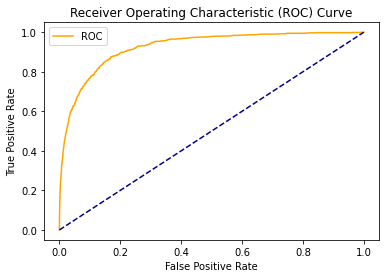

In [40]:
plot_roc_cur(fper,tper)